In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config

batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  figure, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    images = images.detach()[:64]

    show_images(denormalize(images))
    break

show_batch(dataloader)

In [ ]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [12]:
from torch.nn import BCELoss
def save_samples(index, noises, show=True):
  images = generator(noises)

  filename = f'output-images-{index:0=4d}.png'
  save_image(denormalize(images), os.path.join(output_directory, filename), nrow=8)
  print(f'Saving {filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1, 2, 0))

criterion = BCELoss()
def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_targets = images_targets * 0.9

  images_loss = criterion(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_targets = noises_targets + 0.1

  noises_predictions = discriminator(noises_images)
  noises_loss = criterion(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = criterion(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []
  fid_scores = []

  optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images, _ in tqdm(dataloader):
      images = images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)
    fid = calculate_fretchet(images, constant_noise, generator)
    fid_scores.append(fid)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
      f" fid_score: {fid:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores


In [ ]:
from torch.nn.functional import adaptive_avg_pool2d
from numpy.linalg import linalg
import numpy as np
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
  model.eval()
  act = np.empty((len(images), dims))

  if cuda:
    batch = images.cuda()
  else:
    batch = images
  pred = model(batch)[0]

  # If model output is not scalar, apply global spatial average pooling.
  # This happens if you choose a dimensionality not equal 2048.
  if pred.size(2) != 1 or pred.size(3) != 1:
    pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

  act = pred.cpu().data.numpy().reshape(pred.size(0), -1)

  mu = np.mean(act, axis=0)
  sigma = np.cov(act, rowvar=False)
  return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
  mu1 = np.atleast_1d(mu1)
  mu2 = np.atleast_1d(mu2)

  sigma1 = np.atleast_2d(sigma1)
  sigma2 = np.atleast_2d(sigma2)

  assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
  assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

  diff = mu1 - mu2

  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
  if not np.isfinite(covmean).all():
    msg = ('fid calculation produces singular product; '
           'adding %s to diagonal of cov estimates') % eps
    print(msg)
    offset = np.eye(sigma1.shape[0]) * eps
    covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

  if np.iscomplexobj(covmean):
    if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
      m = np.max(np.abs(covmean.imag))
      raise ValueError('Imaginary component {}'.format(m))
    covmean = covmean.real

  tr_covmean = np.trace(covmean)

  return (diff.dot(diff) + np.trace(sigma1) +
          np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real, images_fake, model):
  mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
  mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)

  fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
  return fid_value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving output-images-0000.png


  0%|          | 0/4 [00:00<?, ?it/s]

RuntimeError: Given transposed=1, weight of size [128, 512, 4, 4], expected input[116, 3, 64, 64] to have 128 channels, but got 3 channels instead

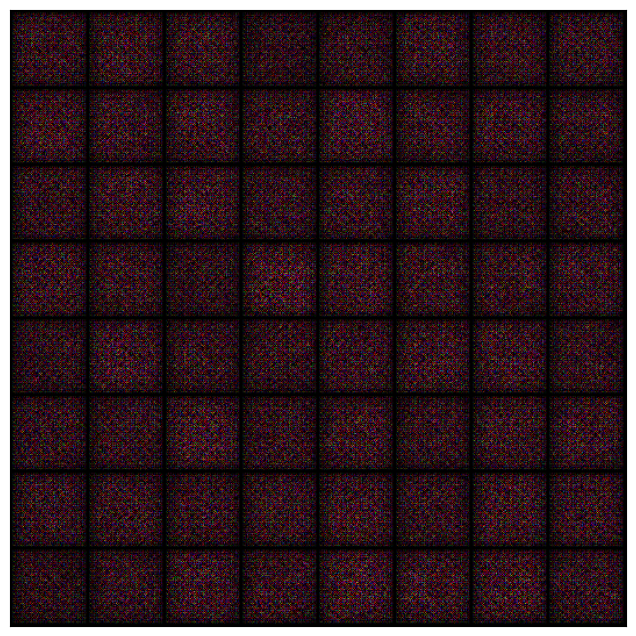

In [15]:
scales = [64]
learning_rate = 0.0002
epochs = 50

for generator_scale in scales:
  generator = (
    Generator(use_gpu=config.use_gpu, scale=generator_scale)
    .apply(initialize_weights)
    .to(device)
  )

  for discriminator_scale in reversed(scales):
    discriminator = (
      Discriminator(use_gpu=config.use_gpu, scale=discriminator_scale)
      .apply(initialize_weights)
      .to(device)
    )

    output_directory = f'results/{generator_scale}-{discriminator_scale}'
    model_directory = f'models/{generator_scale}-{discriminator_scale}'
    os.makedirs(output_directory, exist_ok=True)

    os.makedirs(output_directory, exist_ok=True)
    constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(0, constant_noise)

    history = fit(
      discriminator,
      generator,
      dataloader,
      epochs=epochs,
      learning_rate=learning_rate
    )

    torch.save(generator.state_dict(), f'{model_directory}-generator.pt')
    torch.save(discriminator.state_dict(), f'{model_directory}-discriminator.pt')


# generator.load_state_dict(torch.load('generator.pt'))
# discriminator.load_state_dict(torch.load('discriminator.pt'))